In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.nn.functional import sigmoid
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


### Load data

In [3]:
# Load data
base_path = os.getcwd()
data_path = os.path.join(base_path, 'data')
filename = os.path.join(data_path, 'encoded_recipient_donor_op_df.csv')

data = pd.read_csv(filename)

print(f"Total number of features (in_feature): {len(data.columns.drop(['CASEID', 'readm30daydc']))}\n")
print(f"Total number of patients: {len(data)}\n")
print(data.columns)
display(data.head())

Total number of features (in_feature): 114

Total number of patients: 2354

Index(['CASEID', 'GENDER', 'ETHNICITY_RACE_Asian',
       'ETHNICITY_RACE_Black or African American',
       'ETHNICITY_RACE_Hispanic/Latino', 'ETHNICITY_RACE_Other',
       'ETHNICITY_RACE_Unknown/Not Reported', 'ETHNICITY_RACE_White',
       'AGE_TSRF', 'BMI_TSRF',
       ...
       'MFOUTSLUSH_KIDNEYREPERF', 'CIT',
       'BLADDER_TECHNIQUE_Neobladder or Ileal loop',
       'BLADDER_TECHNIQUE_Ureteroneocystotomy',
       'BLADDER_TECHNIQUE_Ureteropyelostomy',
       'BLADDER_TECHNIQUE_Ureteroureterostomy', 'PRBC_UNITSINC', 'PRBC_UNITS',
       'MFOP_OP_END', 'readm30daydc'],
      dtype='object', length=116)


,CASEID,GENDER,ETHNICITY_RACE_Asian,ETHNICITY_RACE_Black or African American,ETHNICITY_RACE_Hispanic/Latino,ETHNICITY_RACE_Other,ETHNICITY_RACE_Unknown/Not Reported,ETHNICITY_RACE_White,AGE_TSRF,BMI_TSRF,...,MFOUTSLUSH_KIDNEYREPERF,CIT,BLADDER_TECHNIQUE_Neobladder or Ileal loop,BLADDER_TECHNIQUE_Ureteroneocystotomy,BLADDER_TECHNIQUE_Ureteropyelostomy,BLADDER_TECHNIQUE_Ureteroureterostomy,PRBC_UNITSINC,PRBC_UNITS,MFOP_OP_END,readm30daydc
0,100866,1,0.0,0.0,0.0,0.0,0.0,1.0,58,26,...,36,21.300000,0.0,1.0,0.0,0.0,0,2,153,0
1,101068,0,0.0,0.0,0.0,0.0,1.0,0.0,43,25,...,46,4.850000,0.0,1.0,0.0,0.0,0,2,180,0
2,101084,0,0.0,0.0,0.0,0.0,1.0,0.0,23,23,...,39,5.750000,0.0,1.0,0.0,0.0,0,0,152,1
3,101103,1,0.0,0.0,0.0,0.0,0.0,1.0,66,35,...,36,21.283333,0.0,1.0,0.0,0.0,0,0,913,0
4,101586,0,0.0,1.0,0.0,0.0,0.0,0.0,45,22,...,33,15.166667,0.0,1.0,0.0,0.0,0,1,207,0


### Prepare data

In [4]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim: int = 56):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,75),
            nn.ReLU(),
            nn.Linear(75,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x
    
scaler = StandardScaler()
X = data.drop(columns=['CASEID', 'readm30daydc']).values.astype(np.float32)
X = scaler.fit_transform(X)
y = data['readm30daydc'].values.astype(np.float32)

class_weight = torch.tensor([sum(y==0)/sum(y==1)])
print(class_weight)


tensor([3.0586], dtype=torch.float64)



==================== Fold 1 ====================
Epoch [2/10], Training Loss: 2.148 Validation Loss: 2.089
Epoch [10/10], Training Loss: 1.838 Validation Loss: 2.069
0.5028145 0.46731734 0.004847283
Fold 1 AUROC: 0.59
Fold 1 Test Accuracy: 74.7%

==================== Fold 2 ====================
Epoch [2/10], Training Loss: 2.556 Validation Loss: 2.150
Epoch [10/10], Training Loss: 2.136 Validation Loss: 2.120
0.5239433 0.47305134 0.0058441963
Fold 2 AUROC: 0.56
Fold 2 Test Accuracy: 50.5%

==================== Fold 3 ====================
Epoch [2/10], Training Loss: 2.312 Validation Loss: 2.227
Epoch [10/10], Training Loss: 1.962 Validation Loss: 2.200
0.5377735 0.5100132 0.003853577
Fold 3 AUROC: 0.60
Fold 3 Test Accuracy: 24.6%

==================== Fold 4 ====================
Epoch [2/10], Training Loss: 1.945 Validation Loss: 2.219
Epoch [10/10], Training Loss: 1.615 Validation Loss: 2.193
0.5324443 0.51044434 0.003939134
Fold 4 AUROC: 0.57
Fold 4 Test Accuracy: 24.6%

===========

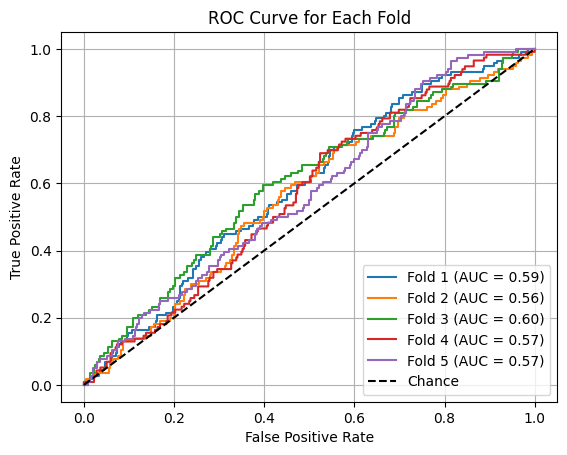

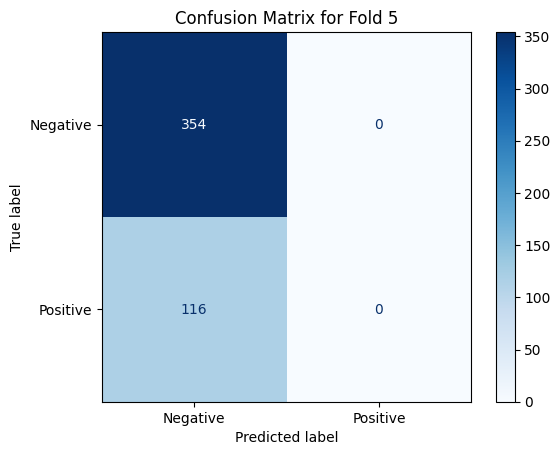

In [5]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_results = {}

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):

    print(f'\n{"="*20} Fold {fold} {"="*20}')
    
    # Split data
    X_train_fold, X_test_fold = torch.tensor(X[train_index]), torch.tensor(X[test_index])
    y_train_fold, y_test_fold = torch.tensor(y[train_index]).unsqueeze(1), torch.tensor(y[test_index]).unsqueeze(1)
    
    # Initialize model
    in_features = X.shape[1]
    model = MLP(in_features)

    # Loss and optimizer
    # Use BCEWithLogitsLoss for numerical stability and apply class weights
    criterion = nn.BCELoss(weight=torch.tensor([3.0586]))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=5)

    # Training loop
    num_epochs = 10
    training_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        outputs = model(X_train_fold)
        train_loss = criterion(outputs, y_train_fold)

        training_loss.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_fold)
            test_loss = criterion(outputs, y_test_fold)
            validation_loss.append(test_loss.item())

        if (epoch+1) % 10 == 0 or epoch == 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss.item():.3f} Validation Loss: {test_loss.item():.3f}")
        
        scheduler.step(test_loss)  # Pass validation loss to scheduler
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_fold)
        loss = criterion(outputs, y_test_fold)
        y_prob = outputs.squeeze().numpy()
        print(max(y_prob), min(y_prob), np.std(y_prob))
        y_pred = (y_prob >= 0.5).astype(int)
        y_true = y_test_fold.squeeze().numpy().astype(int)

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"Fold {fold} AUROC: {roc_auc:.2f}")

    plt.plot(fpr,tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Fold {fold} Test Accuracy: {accuracy*100:.1f}%")
    #print(y_pred)
    fold_results[fold] = {
        "accuracy": accuracy,
        "roc_auc": roc_auc
    }

# Plot the diagonal (chance line)
plt.plot([0, 1], [0, 1], 'k--', label="Chance")

# Configure plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Fold")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Labels are optional for binary classification
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')  # Customize the color map if needed
plt.title(f"Confusion Matrix for Fold {fold}")
plt.show()